## <center> **Анализ результатов A/B-тестирования**
Учащийся: **Станислав Король**

Группа: **DST-136**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro
from statsmodels.stats.proportion import proportions_ztest


def hypo_check(r: list, method: str, H0: str, Ha: str, alpha=0.05):
    print(method)
    print(f'Значение p-value = {r[1]:.2f} ', end='')
    if r[1] < alpha:
        print(f'меньше уровня значимости (alpha) = {alpha}')
        print(f'Принимаем альтернативную гипотезу: {Ha}')
        print(f'Отвергаем нулевую гипотезу: {H0}')
    else:
        print(f'больше или равно уровня значимости (alpha) = {alpha}')
        print(f'Принимаем нулевую гипотезу: {H0}')
        print(f'Отвергаем альтернативную гипотезу: {Ha}')


def proportions_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5
    lower_bound = x_p - eps
    upper_bound = x_p + eps
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma
    diff = xp[1] - xp[0]
    z_crit = -norm.ppf(alpha / 2)
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5
    lower_bound = diff - eps
    upper_bound = diff + eps
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


def proportions_conf_interval_t(n, x_mean, x_std, gamma=0.95):
    k = n - 1
    alpha = 1 - gamma
    t_crit = -t.ppf(alpha/2, k)
    eps = t_crit * x_std/(n ** 0.5)
    lower_bound = x_mean - eps
    upper_bound = x_mean + eps
    return round(lower_bound), round(upper_bound)

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
d = pd.read_csv('data/ab_data_tourist.zip')
d.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?

In [4]:
d['date'] = pd.to_datetime(d['date'], format='%Y-%m-%d')

d_piv = d.groupby(['group']).agg(
    min=('date', 'min'),
    max=('date', 'max'),
    visits=('user_id', 'count'),
    purchases=('purchase', 'sum'),
    total=('price', 'sum')
)

date_range_a = f'{str(d_piv.loc["A"]["min"].date())} \
- {str(d_piv.loc["A"]["max"].date())}'
date_range_b = f'{str(d_piv.loc["B"]["min"].date())} \
- {str(d_piv.loc["B"]["max"].date())}'

print(f'''Периоды наблюдения
Группа A: {date_range_a}
Группа B: {date_range_b}''')

Периоды наблюдения
Группа A: 2021-01-02 - 2021-01-24
Группа B: 2021-01-02 - 2021-01-24


## **Задание 7.3**

* Чему равно количество посещений сайта в группах А и B?
* Чему равно суммарное количество покупок в группах А и B?
* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
print(f'''Количество посещений сайта
Группа A: {d_piv.loc['A']['visits']}
Группа B: {d_piv.loc['B']['visits']}

Суммарное количество покупок
Группа A: {d_piv.loc['A']['purchases']}
Группа B: {d_piv.loc['B']['purchases']}

Суммарное всех покупок
Группа A: {round(d_piv.loc['A']['total']/1000000, 2)} млн. руб.
Группа B: {round(d_piv.loc['B']['total']/1000000, 2)} млн. руб.''')

Количество посещений сайта
Группа A: 147202
Группа B: 147276

Суммарное количество покупок
Группа A: 17723
Группа B: 17514

Суммарное всех покупок
Группа A: 1436.26 млн. руб.
Группа B: 1554.1 млн. руб.


## **Задание 7.4**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*

In [6]:
user_set_a = set(d[d['group'] == 'A']['user_id'])
user_set_b = set(d[d['group'] == 'B']['user_id'])
user_intersection = user_set_a.intersection(user_set_b)

print(f'Количество пользователей, которые попали в обе тестовые группы:\
 {len(user_intersection)}')

Количество пользователей, которые попали в обе тестовые группы: 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
d = d[d['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

| group | count_visits | count_purchases | sum_price |
|-|-|-|-|
| A | ? | ? | ? |
| B | ? | ? | ? |
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?

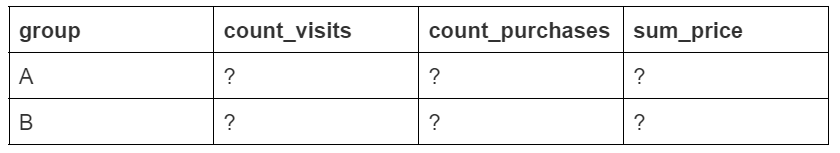

In [8]:
d_total_piv = d.groupby(['group']).agg(
    count_visits=('user_id', 'count'),
    count_purchases=('purchase', 'sum'),
    sum_price=('price', 'sum')
)

visits_a = d_total_piv.loc['A']['count_visits']
visits_b = d_total_piv.loc['B']['count_visits']

display(d_total_piv.reset_index())

print(f'''Количество посещений сайта
Группа A: {visits_a}
Группа B: {visits_b}''')

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Количество посещений сайта
Группа A: 145307
Группа B: 145381


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

**Выводы:** Количество посещений для посадочной страницы группы A - 145307, группы B - 145381. Количество посещений можно считать одинаковым, т.к. разница составляет 74 посещения, что составляет 0,05% - её мы будет считать погрешностью. Соответственно данные групп A и B сопоставимы и можно продолжать анализ вариантов посадочных страниц.

## **Задание 7.6**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %;
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [9]:
d_total_piv['conversion'] = \
    d_total_piv['count_purchases']/d_total_piv['count_visits']
d_total_piv['mean_check'] = \
    d_total_piv['sum_price'] / d_total_piv['count_purchases']

conv_a = round(d_total_piv.loc['A']['conversion'] * 100, 2)
conv_b = round(d_total_piv.loc['B']['conversion'] * 100, 2)
check_a = round(d_total_piv.loc['A']['mean_check'])
check_b = round(d_total_piv.loc['B']['mean_check'])

print(f'''Конверсия
Группа A: {conv_a}%
Группа B: {conv_b}%

Средний чек
Группа A: {check_a} рублей
Группа B: {check_b} рублей''')

Конверсия
Группа A: 12.03%
Группа B: 11.89%

Средний чек
Группа A: 81076 рублей
Группа B: 88665 рублей


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

**Выводы:** Конверсия группы A выше конверсии группы B на 0,14%. Средний чек на группы A меньше среднего чека группы B на 7589 руб. Группа A по показателю конверсии незначительно эффективнее группы B, а по показателю среднего чека группа B эффективнее группы A.

## **Задание 7.7**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура.

In [10]:
d_purpower_piv = d.pivot_table(
    values='purchase',
    index='group',
    columns='price',
    aggfunc='count'
)

d_purpower_piv

price,0,10000,60000,100000,150000,200000
group,,,,,,
A,127820,5182,5271,1832,3478,1724
B,128091,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией.

Чему равно количество проданных туров за 60000 рублей в группах?

Количество туров проданных за 60000 рублей
Группа A: 5271
Группа B: 1730


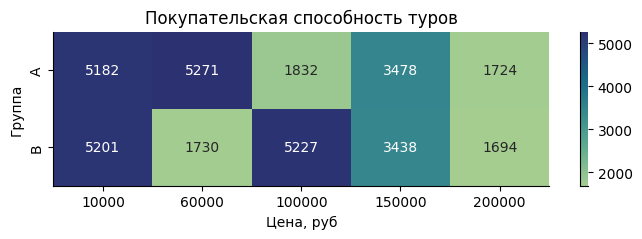

In [11]:
# Удаляем столбец нулевой цены для большей информативности тепловой карты
d_purpower_piv.drop(0, axis=1, inplace=True)

fig, axes = plt.subplots(figsize=(8, 2))
group_sale_hm = sns.heatmap(
    data=d_purpower_piv,
    cmap='crest',
    annot=True,
    fmt='.0f'
)
group_sale_hm.set(
    xlabel='Цена, руб',
    ylabel='Группа',
    title='Покупательская способность туров'
)
sns.despine()

print(f'''Количество туров проданных за 60000 рублей
Группа A: {d_purpower_piv.loc['A'][60000]}
Группа B: {d_purpower_piv.loc['B'][60000]}''')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

**Выводы:** Количество проданных туров в ценовых группах 10000, 150000 и 200000 для групп A и B отличаются незначительно и мы предполагаем, что количество продаж не зависит от вариантов посадочной страницы. В ценовой группе 60000 продажи в группе A превышают продажи в группе B в 3 раза. А в ценовой группе 100000 продажи в группе B превышают продажи в группе A примерно в 3 раза. Следовательно вариант посадочной страницы группы A более эффективен для продажи билетов в Турцию (60000 руб), а вариант группы B более эффективен для продажи билетов в Таиланд (100000 руб). В общем вариант посадочной страницы группы B более эффективен, т.к. приносит компании больше выручки за счёт более эффективной продажи дорогих туров в Таиланд.

## **Задание 7.8**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок).
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых;
* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [12]:
d_daily_piv = d.groupby(['group', 'date']).agg(
    count_visits=('user_id', 'count'),
    count_purchases=('purchase', 'sum'),
    sum_price=('price', 'sum')
)
d_daily_piv['conversion'] = \
    d_daily_piv['count_purchases'] / d_daily_piv['count_visits']
d_daily_piv['mean_check'] = \
    d_daily_piv['sum_price'] / d_daily_piv['count_purchases']

conv_a = round(d_daily_piv.loc[('A', '2021-01-03')]['conversion'] * 100, 2)
conv_b = round(d_daily_piv.loc[('B', '2021-01-03')]['conversion'] * 100, 2)

mean_ch_a = round(d_daily_piv.loc[('A', '2021-01-03')]['mean_check'])
mean_ch_b = round(d_daily_piv.loc[('B', '2021-01-03')]['mean_check'])

print(f'''Конверсия на 3-е января 2021 года
Группа A: {conv_a}%
Группа B: {conv_b}%

Средний чек на 3-е января 2021 года
Группа A: {mean_ch_a} руб
Группа B: {mean_ch_b} руб''')

Конверсия на 3-е января 2021 года
Группа A: 11.34%
Группа B: 11.39%

Средний чек на 3-е января 2021 года
Группа A: 82888 руб
Группа B: 87480 руб


## **Задание 7.9** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [13]:
d_daily_piv.sort_values(['group', 'date'], inplace=True)

d_daily_piv['csum_visits'] = \
    d_daily_piv.groupby(['group'])['count_visits'].cumsum()
d_daily_piv['csum_purchases'] = \
    d_daily_piv.groupby(['group'])['count_purchases'].cumsum()
d_daily_piv['csum_price'] = \
    d_daily_piv.groupby(['group'])['sum_price'].cumsum()

d_daily_piv['csum_conversion'] = \
    d_daily_piv['csum_purchases'] / d_daily_piv['csum_visits']
d_daily_piv['csum_mean_check'] = \
    d_daily_piv['csum_price'] / d_daily_piv['csum_purchases']

cconv_b = round(
    d_daily_piv.loc[('B', '2021-01-20')]['csum_conversion'] * 100, 2
)
cmean_ch_a = round(d_daily_piv.loc[('A', '2021-01-12')]['csum_mean_check'])

print(f'''Кумулятивная конверсия на 20.01.2021 года в группе B: {cconv_b}%
Кумулятивный средний чек на 12.01.2021 года в группе A: {cmean_ch_a} руб''')

Кумулятивная конверсия на 20.01.2021 года в группе B: 11.9%
Кумулятивный средний чек на 12.01.2021 года в группе A: 81492 руб


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

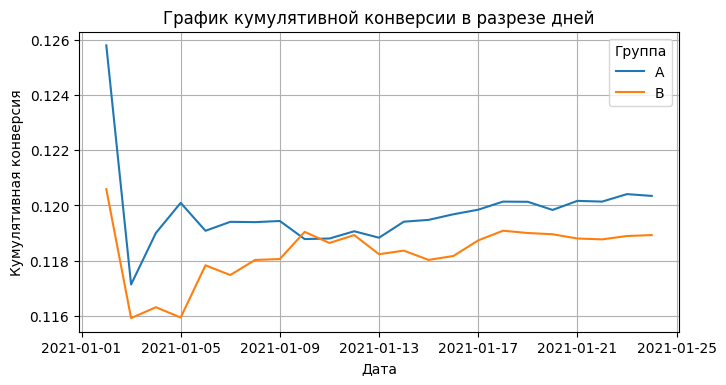

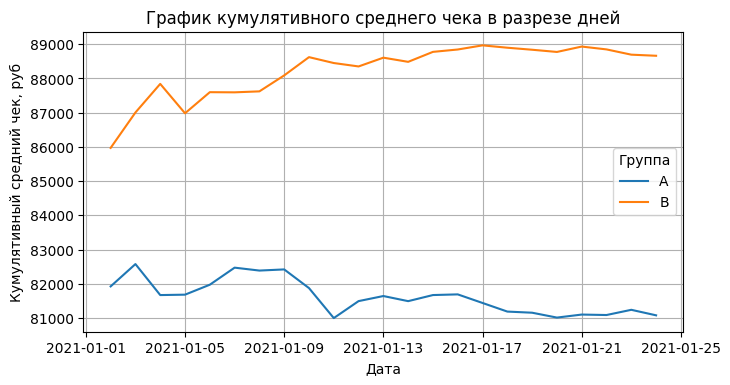

In [14]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(
    data=d_daily_piv,
    x='date',
    y='csum_conversion',
    hue='group',
    ax=ax
)
ax.set(
    xlabel='Дата',
    ylabel='Кумулятивная конверсия',
    title='График кумулятивной конверсии в разрезе дней'
)
plt.legend(title='Группа')
ax.grid();

fig = plt.figure(figsize=(6, 3))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(
    data=d_daily_piv,
    x='date',
    y='csum_mean_check',
    hue='group',
    ax=ax
)
ax.set(
    xlabel='Дата',
    ylabel='Кумулятивный средний чек, руб',
    title='График кумулятивного среднего чека в разрезе дней'
)
plt.legend(title='Группа')
ax.grid();

**Выводы:** По графику кумулятивной конверсии видно, что данные в группе A и B стабилизируются после 15.01.2021 года, соответственно A/B-тест можно считать завершённым по метрике конверсии. Так же видно, что кумулятивная конверсия в группе A стабильно выше конверсии группы B на 10%, после 15.01.2021. По графику кумулятивного среднего чека видно, что графики группы A и B стабилизируются после 12.01.2021,соответственно A/B-тест можно считать завершённым по метрике суммы среднего чека. График группы A стабилизируется на значении среднего чека в 81000 руб, а график группы B стабилизируется на значении среднего чека около 88500 руб. По информации обоих графиков видно, что даже при более низкой конверсии посадочной страницы группы B, этот вариант страницы более эффективен, чем вариант группы A и приносит больше выручки компании.

## **Задание 7.10**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [15]:
hypo_check(
    proportions_ztest(
        count=d_total_piv['count_purchases'],
        nobs=d_total_piv['count_visits'],
        alternative='larger',
    ),
    method='Z-тест для пропорций (больше)',
    H0='Конверсии в группах А и B равны',
    Ha='Конверсия в группе А выше, чем конверсия в группе B'
)

Z-тест для пропорций (больше)
Значение p-value = 0.12 больше или равно уровня значимости (alpha) = 0.05
Принимаем нулевую гипотезу: Конверсии в группах А и B равны
Отвергаем альтернативную гипотезу: Конверсия в группе А выше, чем конверсия в группе B


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

**Выводы:** Z-тест для пропорций показал, что истинные значения конверсий в группах равны (при $\alpha$=0.05), следовательно полученная разница метрики в группах статистически не значима. Таким образом разницы в конверсии между вариантами посадочной страницы группы A и группы B - нет. Группы A и B статистически одинаковы по метрике конверсии.

## **Задание 7.11**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах.

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [16]:
conf_interval_a = proportions_conf_interval(
    n=d_total_piv.loc['A']['count_visits'],
    x_p=d_total_piv.loc['A']['conversion']
)

conf_interval_b = proportions_conf_interval(
    n=d_total_piv.loc['B']['count_visits'],
    x_p=d_total_piv.loc['B']['conversion']
)

n = [
    d_total_piv.loc['A']['count_visits'],
    d_total_piv.loc['B']['count_visits']
]
xp = [
    d_total_piv.loc['A']['conversion'],
    d_total_piv.loc['B']['conversion']
]
diff_inverval = diff_proportions_conf_interval(n, xp)

print(f'''Доверительные интервалы, %
Группа A: {conf_interval_a}
Группа B: {conf_interval_b}
Разность конверсий групп A и B: {diff_inverval}''')

Доверительные интервалы, %
Группа A: (11.87, 12.2)
Группа B: (11.73, 12.06)
Разность конверсий групп A и B: (-0.38, 0.09)


Интерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

**Выводы:** На основании расчётов видно, что с надёжностью в 95% конверсия группы А лежит в интервале от 11.87% до 12.2%, а конверсия группы B лежит в интервале от 11.73% до 12.06%. Доверительные интервалы групп A и B пересекаются в интервале с 11,87% по 12,06% - следовательно существует вероятность, что истинное значение конверсии в обеих группах может попасть в этот интервал. Построенный доверительный интервал с надёжностью в 95% говорит нам, что разница в конверсии между вариантом группы A и вариантом группы B лежит в интервале от -0.38% до 0.09%. То есть разница в конверсии с 95%-ой надёжностью может быть как положительной, так и отрицательной. Интервал охватывает точку 0 - соответственно мы имеем дело с третьим случаем. Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами групп А и B не существует, то есть они являются равнозначными по метрике конверсии.

## **Задание 7.12**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$=0.05?

In [17]:
hypo_check(
    shapiro(d_daily_piv.loc['A']['mean_check']),
    method='Тест Шапиро-Уилка',
    H0='Данные группы A распределены нормально',
    Ha='Данные группы A не распределены нормально'
)
print()
hypo_check(
    shapiro(d_daily_piv.loc['B']['mean_check']),
    method='Тест Шапиро-Уилка',
    H0='Данные группы B распределены нормально',
    Ha='Данные группы B не распределены нормально'
)

Тест Шапиро-Уилка
Значение p-value = 0.25 больше или равно уровня значимости (alpha) = 0.05
Принимаем нулевую гипотезу: Данные группы A распределены нормально
Отвергаем альтернативную гипотезу: Данные группы A не распределены нормально

Тест Шапиро-Уилка
Значение p-value = 0.09 больше или равно уровня значимости (alpha) = 0.05
Принимаем нулевую гипотезу: Данные группы B распределены нормально
Отвергаем альтернативную гипотезу: Данные группы B не распределены нормально


## **Задание 7.13**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B.

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [18]:
hypo_check(
    ttest_ind(
        a=d_daily_piv.loc['A']['mean_check'],
        b=d_daily_piv.loc['B']['mean_check'],
        alternative='less'
    ),
    method='T-тест средних значений (меньше)',
    H0='Сумма среднего чека в группах A и B одинаковая',
    Ha='Сумма среднего чека в группе А меньше, чем в группе B'
)

T-тест средних значений (меньше)
Значение p-value = 0.00 меньше уровня значимости (alpha) = 0.05
Принимаем альтернативную гипотезу: Сумма среднего чека в группе А меньше, чем в группе B
Отвергаем нулевую гипотезу: Сумма среднего чека в группах A и B одинаковая


Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

**Выводы:** T-тест для сравнения средних (при $\alpha$=0.05) показал, что сумма среднего чека больше в группе B. Следовательно статистическая разница между суммами средних чеков групп A и B - значима. Таким образом вариант посадочной страницы группы B более эффективен, чем вариант группы A по метрике суммы среднего чека.

## **Задание 7.14**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [19]:
confidence_interval_a = proportions_conf_interval_t(
    n=d_daily_piv.loc['A']['mean_check'].count(),
    x_mean=d_daily_piv.loc['A']['mean_check'].mean(),
    x_std=d_daily_piv.loc['A']['mean_check'].std()
)

confidence_interval_b = proportions_conf_interval_t(
    n=d_daily_piv.loc['B']['mean_check'].count(),
    x_mean=d_daily_piv.loc['B']['mean_check'].mean(),
    x_std=d_daily_piv.loc['B']['mean_check'].std()
)

print(f'''Доверительные интервалы, руб
Группа A: {confidence_interval_a}
Группа B: {confidence_interval_b}''')

Доверительные интервалы, руб
Группа A: (79630, 82308)
Группа B: (87626, 89526)


Интерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

**Выводы:** На основании расчётов видно, что с надёжностью в 95% сумма среднего чека варианта посадочной страницы группы А лежит в интервале от 79630 руб до 82308 руб, а сумма среднего чека варианта посадочной таблицы группы B лежит в интервале от 87626 руб до 89526 руб. Доверительные интервалы групп A и B не пересекаются - следовательно истинное значение суммы среднего чека группы A и группы B никогда не совпадёт (что видно и на графике, см. задание 7.9). Вариант посадочной страницы группы B всегда даёт сумму среднего чека выше на 9%, чем вариант группы A. Следовательно для получения большей выручки, необходимо использовать вариант посадочной страницы группы B.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

**Выводы:** В ходе анализа данных посещения и покупок двух вариантов посадочной страницы групп A и B было опредлено, что:
* Посадочная страница группы B более эффективна в продаже более дорогих туров в Таиланд;
* По метрике конверсии различия вариантов посадочных страниц групп A и B статистически не значительны;
* По метрике суммы среднего чека вариант страницы группы B стабильно выше на 9% среднего чека группы A.

Следовательно для получения большей выручки, необходимо использовать вариант посадочной страницы группы B.